In [1]:
BATCH_SIZE = 32
INPUT_SHAPE = (25, 16, 1)
DATASET_PATH = "output_frames"
DATASET_ZIP = "dataset.zip"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [2]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

2025-03-12 14:43:52.205738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 14:43:52.210526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 14:43:52.223031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741787032.251382  157205 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741787032.259927  157205 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741787032.276351  157205 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

No GPU detected.


E0000 00:00:1741787035.843276  157205 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1741787035.844250  157205 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [6]:
# Function to load a ZIP file from Google Drive.
def load_zip_file(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract to a specific directory
            zip_ref.extractall(DATASET_PATH)
            print(f"ZIP file '{zip_path}' loaded successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at '{zip_path}'.")
    except zipfile.BadZipFile:
        print(f"Error: Invalid ZIP file at '{zip_path}'.")

# If in Colab, load the ZIP file from Google Drive.
if IN_COLAB:
    print("Loading and extracting dataset ZIP-file form Drive.")
    if (not os.path.exists(DATASET_PATH)):
        load_zip_file("drive/MyDrive/Studies/KTH/Courses/II143X/Model Creation/Data/output_frames.zip")
        
# Otherwise, check of files exist.
else:
    print("No Colab detected, using pre-existing files.")
    if (not os.path.exists(DATASET_PATH)):
        print("Error: Dataset not found.")
        sys.exit()

No Colab detected, using pre-existing files.


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [7]:
# Prepare dataset array and labels array.
dataset = []
labels = []
for directory in os.listdir(DATASET_PATH):
    if os.path.isdir(os.path.join(DATASET_PATH, directory)):
        if (directory not in labels):
            labels.append(directory)
        for file in os.listdir(os.path.join(DATASET_PATH, directory)):
            if file.endswith(".txt"):
                dataset.append([os.path.join(DATASET_PATH, directory, file), directory])

In [8]:
print(f"Example file: {dataset[0]}")
print(f"Labels: {labels}")

Example file: ['output_frames/bus/Y00Em9rI2Cu8_30.000_40.000_frame_number\uf03a35.txt', 'bus']
Labels: ['bus', 'motorcycle', 'bicycle', 'car', 'truck', 'background_noise']


In [9]:
for label in labels:
    print(f"Amount of '{label}': {len([x for x in dataset if x[1] == label])}")

Amount of 'bus': 3815
Amount of 'motorcycle': 3844
Amount of 'bicycle': 3834
Amount of 'car': 3827
Amount of 'truck': 3829
Amount of 'background_noise': 7600


In [10]:
# Read content of a TXT file and return the content as a NumPy array.
def readTXTFile(file_path):
    if not os.path.isfile(file_path):
        print(f"Error: File not found at '{file_path}'.")
        return
    if not file_path.endswith(".txt"):
        print(f"Error: File at '{file_path}' is not a TXT file.")
        return
    with open(file_path, 'r') as file:
        mfcc_txt = file.read()
        mfcc_data = np.array(eval(mfcc_txt)).T
        return mfcc_data

In [11]:
# Plot MFCC
def plot_mfcc(mfccs):
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


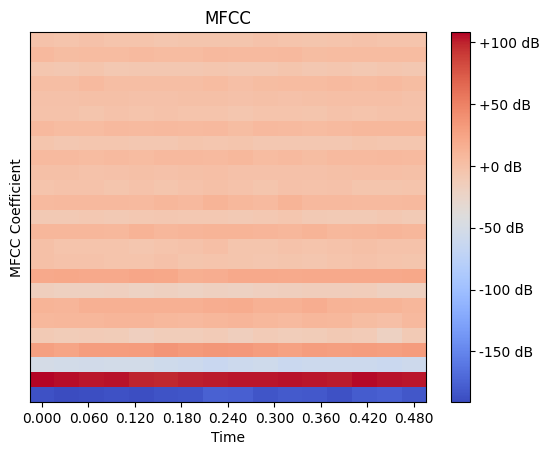

In [12]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(readTXTFile(dataset[0][0]))

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [13]:
# Split the dataset into training and testing sets.
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Split the training set into training and validation sets.
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

# Store lengths of the sets.
train_len = len(train_set)
val_len = len(val_set)
test_len = len(test_set)

print(f"Training set length: {train_len}")
print(f"Validation set length: {val_len}")
print(f"Testing set length: {test_len}")

Training set length: 17119
Validation set length: 4280
Testing set length: 5350


### Optimizing RAM Usage With interleave()

interleave(), used for efficient dataset loading by interleaving elements from multiple datasets, works by loading batches of data whenever needed, processes it, passes it to the model, and then removes the data. By doing this, we save RAM and can thus make use of larger datasets. Note however that the files it loads must be large to prevent I/O bottlenecks.

In [14]:
# Separate file paths and labels
train_file_paths = [item[0] for item in train_set]
train_labels = [item[1] for item in train_set]
val_file_paths = [item[0] for item in val_set]
val_labels = [item[1] for item in val_set]

# One-hot encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
train_labels = to_categorical(label_encoder.transform(train_labels))
val_labels = to_categorical(label_encoder.transform(val_labels))

In [15]:
# Define the processTXTFile_tf function
def processTXTFile_tf(file_path):
    # As the file_path is a tensor, we need to decode it
    file_path = file_path.numpy().decode('utf-8')
    # Get MFCC NP array
    mfccArray = readTXTFile(file_path)
    # Convert to tensor
    tensor = tf.convert_to_tensor(mfccArray, dtype=tf.float16)
    # Return the tensor
    return tensor

# Create a dataset from a file path
def pathToDataset(file_path):
    return (
        tf.data.Dataset.from_tensor_slices(file_path).interleave(
            lambda file: tf.data.Dataset.from_tensors(
                tf.py_function(processTXTFile_tf, [file], [tf.float16]) # Process the file
            ).map(lambda x: tf.reshape(x, INPUT_SHAPE)),                # Ensure correct shape
            num_parallel_calls=tf.data.AUTOTUNE
        )
    )

# Create the x_train_tf dataset
x_train_tf = pathToDataset(train_file_paths)
# Create the y_train_tf dataset
y_train_tf = tf.data.Dataset.from_tensor_slices(train_labels)
# Combine x_train_tf and y_train_tf into a single dataset
train_tf = tf.data.Dataset.zip((x_train_tf, y_train_tf)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the x_val_tf dataset
x_val_tf = pathToDataset(val_file_paths)
# Create the y_val_tf dataset
y_val_tf = tf.data.Dataset.from_tensor_slices(val_labels)
# Combine x_val_tf and y_val_tf into a single dataset
val_tf = tf.data.Dataset.zip((x_val_tf, y_val_tf)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [16]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss']) 

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [17]:
# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, train_tf, val_tf, epochs, doPrintHistory, verbose=1):
    history = model.fit(train_tf, validation_data=val_tf, epochs=epochs, verbose=verbose, steps_per_epoch=train_len // BATCH_SIZE)
    # Print history
    if doPrintHistory: printHistory(history)

# Construct Sequantial Model

...

In [18]:
# Creation of the sequential model
sequential_model = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = 'same', input_shape = INPUT_SHAPE),
    Conv2D(filters = 64, kernel_size = (2,2), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dropout(0.6),
    Dense(units = len(labels), activation = "softmax")
])


/home/william/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Print a summary of the model architecture
sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 16, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,934 (1.88 MB)

 Trainable params: 492,934 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model.
sequential_model.compile(
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ['categorical_accuracy']
)

In [21]:
fitModel(sequential_model, train_tf, val_tf, 16, True)

Epoch 1/16
  3/534 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - categorical_accuracy: 0.1840 - loss: 6.1944

2025-03-12 14:43:58.855268: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.
2025-03-12 14:43:58.855333: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.
2025-03-12 14:43:58.926622: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.
2025-03-12 14:43:58.927875: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.
2025-03-12 14:43:59.014240: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.


 38/534 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - categorical_accuracy: 0.2278 - loss: 3.0777

KeyboardInterrupt: 